# Proyecto "Image Denoising"

Carlos Sánchez Polo y Jesús Martínez Leal

In [1]:
#NumPy: numerical scientific computing 
import numpy as np

#Scikit-learn: machine learning
from sklearn.decomposition import PCA, KernelPCA

#Matplotlib: plotting 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

#SciPy: scientific tools
import scipy.io.matlab as matlab

#OpenCV: computer vision
import cv2


# Carga de los datos

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True, parser='auto')
X = MinMaxScaler().fit_transform(X)

Dividimos en train y test e introducimos ruido a las imágenes.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, train_size=1_000, test_size=100)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

# Representación de las imágenes

In [4]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)


La siguiente función permite presentar dos bloques de números en paralelos para comparar. Por ejemplo las imágenes con ruido, y las imágenes tratadas para reducirlo.

In [10]:
def plot_parallel(X_clean, X_noisy, title_clean, title_noisy):
    """Small helper function to plot 100 digits."""
    # Creamos una figura más ancha para acomodar ambos conjuntos de datos
    fig, axs = plt.subplots(nrows=10, ncols=20, figsize=(10, 5)) 

    # Título y posición central para datos limpios
    axs[0, 4].set_title(title_clean, fontsize=10)

    # Título y posición central para datos ruidosos
    axs[0, 14].set_title(title_noisy, fontsize=10)

    for i in range(10):
        # Plot clean data
        for j, img in enumerate(X_clean[i*10:(i+1)*10]): # Los primeros 10 subplots para los datos limpios
            ax = axs[i, j]
            ax.imshow(img.reshape((16, 16)), cmap="Greys")
            ax.axis("off")

        # Plot noisy data
        for j, img in enumerate(X_noisy[i*10:(i+1)*10]): # Los siguientes 10 subplots para los datos ruidosos
            ax = axs[i, j+10]
            ax.imshow(img.reshape((16, 16)), cmap="Greys")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

Vamos a usar el Mean Square Error (o error cuadrático medio) como medida del error. Cuando limpiemos las imágenes, tendremos que tener alguna referencia que nos permita de forma numérica saber si nuestras imágenes están mejor o peor que antes.

In [12]:
def calcular_mse(nuevas, originales=X_train):
    num_imagenes = len(originales)
    total_mse = 0.0

    for i in range(num_imagenes):
        mse = np.mean((originales[i] - nuevas[i])**2)
        total_mse += mse

    mse = total_mse / num_imagenes
    return mse

A continuación se ve los números originales y los números tras introducirles ruido

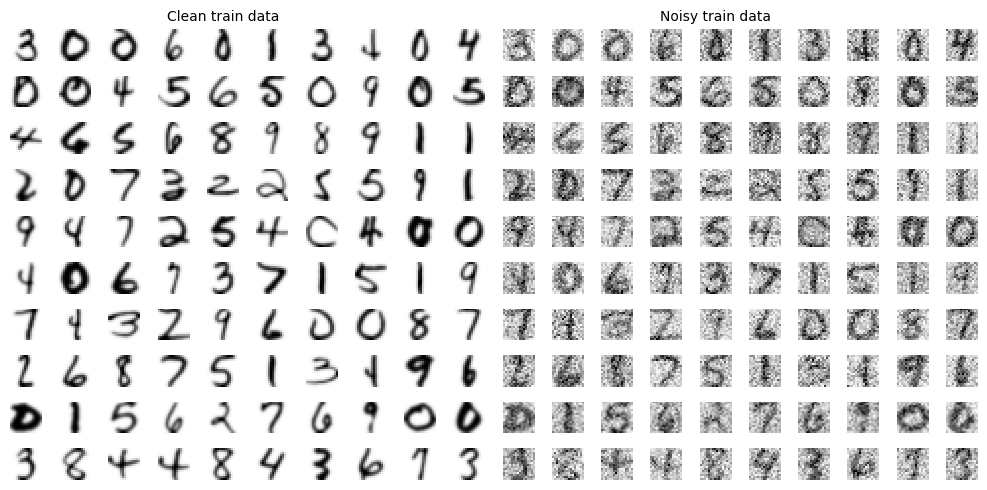

In [11]:
plot_parallel(X_train, X_train_noisy, "Clean train data", "Noisy train data")

# Ejercicio.

### Intenta quitar el ruido de las imágenes de test utilizando los métodos vistos en clase. Cuantifica los resultados cualitativamente y cuantitativamente utilizando MSE. Justifica todas tus respuestas.

Ajustar los hiperparámetros para obtener los mejores resultados posibles (número de componentes, tipo de kernel, gamma ...).

Hemos hecho varias pruebas previas para comprobar en que rango de valores nos debemos mover para quitar el ruido a nuestras imágenes. El procedimiento es el siguiente: Aplicamos KPCA, probando con distintos kernels y valores de gamma. Nos quedamos con el mejor denosing. Sobre ese nuevo conjunto de imágenes procesadas volvemos a aplicar pca de forma iterativa hasta que el MSE alcance un mínimo. Para cada iteración nos guardamos los hiperparámetros de nuestro mejor modelo, que luego aplicaremos a nuestros datos de test, puesto que hasta habremos estado probando con los de entrenamiento.

In [27]:
best_mse = calcular_mse(limpias=X_train_noisy)
recuento = 0

lista = np.arange(0.00125, 0.10001, 0.00125).tolist()


for kernel in ['rbf', 'poly','linear']: 
    for gamma in lista: 
        recuento += 1
        print('Probando modelo ',recuento)
        print('Kernel: ', kernel)
        print('Gamma: ', gamma)

        kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_train_noisy) 
        X_kpca = kpca.transform(X_train_noisy) 
        X_back = kpca.inverse_transform(X_kpca)
        
        mse = calcular_mse(limpias=X_back)
        print("MSE:", mse)
        print("-----")

        if mse < best_mse:
            best_mse = mse
            best_gamma = gamma
            best_kernel = kernel

print("El mejor modelo tiene el siguiente kernel y gamma:") 
print("Kernel:", best_kernel) 
print("Gamma:", best_gamma) 
print("MSE:", best_mse)

Probando modelo  1
Kernel:  rbf
Gamma:  0.00125
MSE: 0.06962651588045617
-----
Probando modelo  2
Kernel:  rbf
Gamma:  0.0025
MSE: 0.06610842368765542
-----
Probando modelo  3
Kernel:  rbf
Gamma:  0.00375
MSE: 0.06173932325213365
-----
Probando modelo  4
Kernel:  rbf
Gamma:  0.005
MSE: 0.0573199362359328
-----
Probando modelo  5
Kernel:  rbf
Gamma:  0.00625
MSE: 0.053239652039903475
-----
Probando modelo  6
Kernel:  rbf
Gamma:  0.007500000000000001
MSE: 0.04963374119603846
-----
Probando modelo  7
Kernel:  rbf
Gamma:  0.008749999999999999
MSE: 0.046513681164407066
-----
Probando modelo  8
Kernel:  rbf
Gamma:  0.01
MSE: 0.04384068706763247
-----
Probando modelo  9
Kernel:  rbf
Gamma:  0.01125
MSE: 0.04156067768986961
-----
Probando modelo  10
Kernel:  rbf
Gamma:  0.012499999999999999
MSE: 0.0396191627578409
-----
Probando modelo  11
Kernel:  rbf
Gamma:  0.01375
MSE: 0.03796681021369573
-----
Probando modelo  12
Kernel:  rbf
Gamma:  0.015
MSE: 0.03656096534820106
-----
Probando modelo  1

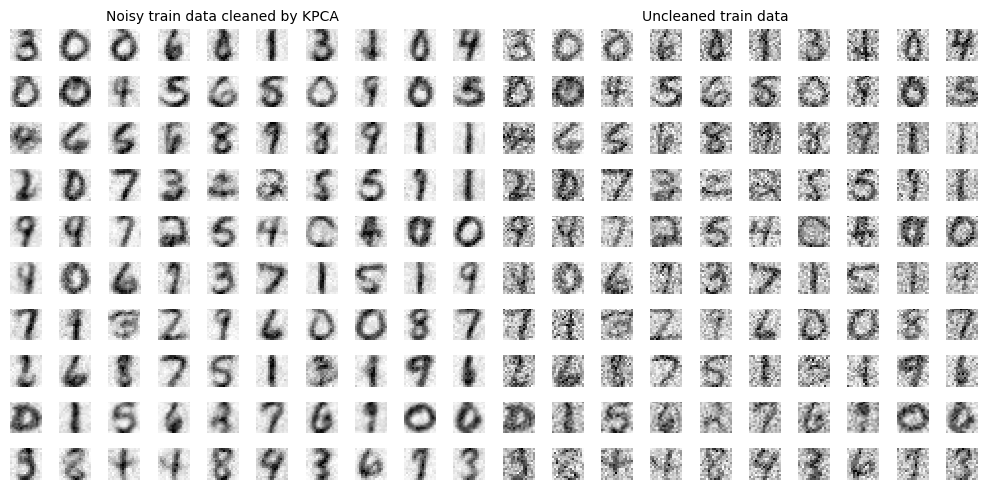

In [28]:
gamma = 0.01375
kernel = 'poly'

kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_train_noisy) 
X_kpca = kpca.transform(X_train_noisy) 
X_back_m1 = kpca.inverse_transform(X_kpca)

plot_parallel(X_back_m1, X_train_noisy, "Noisy train data cleaned by KPCA", "Uncleaned train data")







In [29]:
best_mse = calcular_mse(limpias=X_back_m1)
recuento = 0

lista = np.arange(0.00125, 0.15001, 0.00125).tolist()


for kernel in ['rbf', 'poly']: 
    for gamma in lista: 
        recuento += 1
        print('Probando modelo ',recuento)
        print('Kernel: ', kernel)
        print('Gamma: ', gamma)

        kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_back_m1) 
        X_kpca = kpca.transform(X_back_m1) 
        X_back = kpca.inverse_transform(X_kpca)
        
        mse = calcular_mse(limpias=X_back)
        print("MSE:", mse)
        print("-----")

        if mse < best_mse:
            best_mse = mse
            best_gamma = gamma
            best_kernel = kernel

print("El mejor modelo tiene el siguiente kernel y gamma:") 
print("Kernel:", best_kernel) 
print("Gamma:", best_gamma) 
print("MSE:", best_mse)

Probando modelo  1
Kernel:  rbf
Gamma:  0.00125
MSE: 0.07000273093335209
-----
Probando modelo  2
Kernel:  rbf
Gamma:  0.0025
MSE: 0.06722738200527459
-----
Probando modelo  3
Kernel:  rbf
Gamma:  0.00375
MSE: 0.06357125400846188
-----
Probando modelo  4
Kernel:  rbf
Gamma:  0.005
MSE: 0.059691498175712884
-----
Probando modelo  5
Kernel:  rbf
Gamma:  0.00625
MSE: 0.05596802136550838
-----
Probando modelo  6
Kernel:  rbf
Gamma:  0.007500000000000001
MSE: 0.05256526449039972
-----
Probando modelo  7
Kernel:  rbf
Gamma:  0.008749999999999999
MSE: 0.049526298773441106
-----
Probando modelo  8
Kernel:  rbf
Gamma:  0.01
MSE: 0.04683857395049403
-----
Probando modelo  9
Kernel:  rbf
Gamma:  0.01125
MSE: 0.04446881737467767
-----
Probando modelo  10
Kernel:  rbf
Gamma:  0.012499999999999999
MSE: 0.042378910463243644
-----
Probando modelo  11
Kernel:  rbf
Gamma:  0.01375
MSE: 0.04053229475818251
-----
Probando modelo  12
Kernel:  rbf
Gamma:  0.015
MSE: 0.03889616869246057
-----
Probando modelo

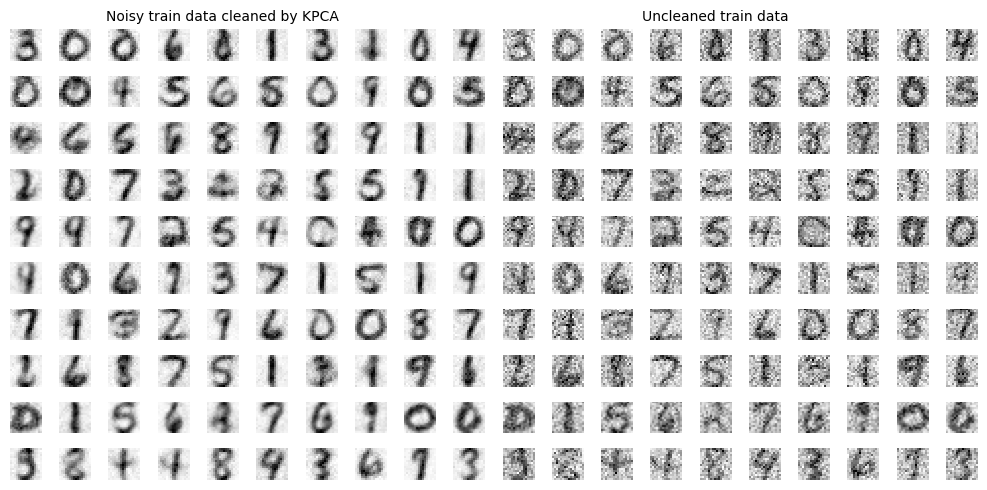

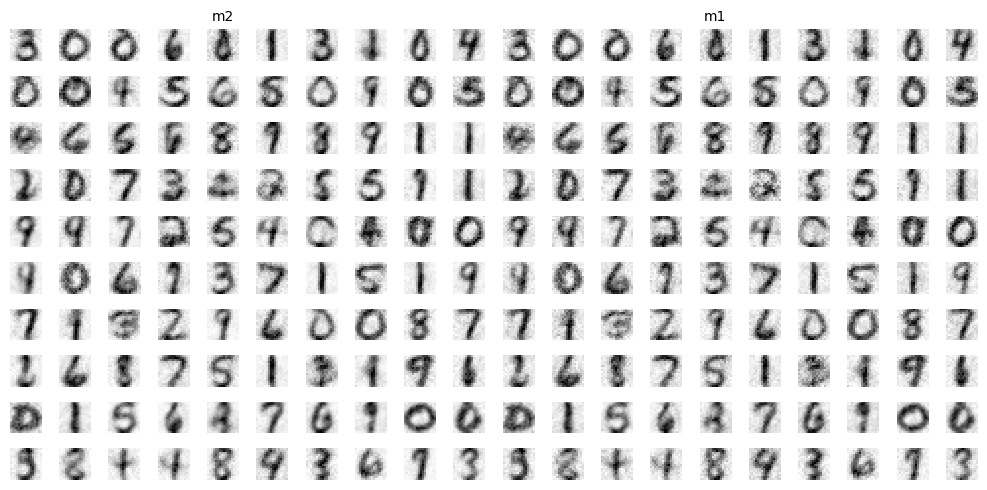

In [31]:


gamma = 0.06625
kernel = 'poly'

kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_back_m1) 
X_kpca = kpca.transform(X_back_m1) 
X_back_m2 = kpca.inverse_transform(X_kpca)

plot_parallel(X_back_m2, X_train_noisy, "Noisy train data cleaned by KPCA", "Uncleaned train data")
plot_parallel(X_back_m2, X_back_m1, "m2", "m1")




In [32]:
best_mse = calcular_mse(limpias=X_back_m1)
recuento = 0

lista = np.arange(0.00125, 0.15001, 0.00125).tolist()


for kernel in ['rbf', 'poly']: 
    for gamma in lista: 
        recuento += 1
        print('Probando modelo ',recuento)
        print('Kernel: ', kernel)
        print('Gamma: ', gamma)

        kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_back_m2) 
        X_kpca = kpca.transform(X_back_m2) 
        X_back = kpca.inverse_transform(X_kpca)
        
        mse = calcular_mse(limpias=X_back)
        print("MSE:", mse)
        print("-----")

        if mse < best_mse:
            best_mse = mse
            best_gamma = gamma
            best_kernel = kernel

print("El mejor modelo tiene el siguiente kernel y gamma:") 
print("Kernel:", best_kernel) 
print("Gamma:", best_gamma) 
print("MSE:", best_mse)

Probando modelo  1
Kernel:  rbf
Gamma:  0.00125
MSE: 0.07000915748354482
-----
Probando modelo  2
Kernel:  rbf
Gamma:  0.0025
MSE: 0.06724713324579466
-----
Probando modelo  3
Kernel:  rbf
Gamma:  0.00375
MSE: 0.06360577181415619
-----
Probando modelo  4
Kernel:  rbf
Gamma:  0.005
MSE: 0.05973985014073499
-----
Probando modelo  5
Kernel:  rbf
Gamma:  0.00625
MSE: 0.05602888262016534
-----
Probando modelo  6
Kernel:  rbf
Gamma:  0.007500000000000001
MSE: 0.05263750191577863
-----
Probando modelo  7
Kernel:  rbf
Gamma:  0.008749999999999999
MSE: 0.04960900684551496
-----
Probando modelo  8
Kernel:  rbf
Gamma:  0.01
MSE: 0.04693101800280363
-----
Probando modelo  9
Kernel:  rbf
Gamma:  0.01125
MSE: 0.044570392626682394
-----
Probando modelo  10
Kernel:  rbf
Gamma:  0.012499999999999999
MSE: 0.042489115009652585
-----
Probando modelo  11
Kernel:  rbf
Gamma:  0.01375
MSE: 0.04065070585388959
-----
Probando modelo  12
Kernel:  rbf
Gamma:  0.015
MSE: 0.039022419994675366
-----
Probando modelo

In [36]:
best_mse = calcular_mse(limpias=X_back_m1)
recuento = 0

lista = np.arange(0.45000, 3.0, 0.01000).tolist()


for kernel in ['rbf', 'poly']: 
    for gamma in lista: 
        recuento += 1
        print('Probando modelo ',recuento)
        print('Kernel: ', kernel)
        print('Gamma: ', gamma)

        kpca = KernelPCA(kernel=kernel, gamma=gamma, fit_inverse_transform=True).fit(X_back_m2) 
        X_kpca = kpca.transform(X_back_m2) 
        X_back = kpca.inverse_transform(X_kpca)
        
        mse = calcular_mse(limpias=X_back)
        print("MSE:", mse)
        print("-----")

        if mse < best_mse:
            best_mse = mse
            best_gamma = gamma
            best_kernel = kernel

print("El mejor modelo tiene el siguiente kernel y gamma:") 
print("Kernel:", best_kernel) 
print("Gamma:", best_gamma) 
print("MSE:", best_mse)

Probando modelo  1
Kernel:  rbf
Gamma:  0.45
MSE: 0.02700034529190903
-----
Probando modelo  2
Kernel:  rbf
Gamma:  0.46
MSE: 0.02708383038463697
-----
Probando modelo  3
Kernel:  rbf
Gamma:  0.47000000000000003
MSE: 0.027163441874486164
-----
Probando modelo  4
Kernel:  rbf
Gamma:  0.48000000000000004
MSE: 0.027239370772138137
-----
Probando modelo  5
Kernel:  rbf
Gamma:  0.49000000000000005
MSE: 0.027311804581966817
-----
Probando modelo  6
Kernel:  rbf
Gamma:  0.5
MSE: 0.02738092628313875
-----
Probando modelo  7
Kernel:  rbf
Gamma:  0.51
MSE: 0.027446913535289743
-----
Probando modelo  8
Kernel:  rbf
Gamma:  0.52
MSE: 0.027509938078289466
-----
Probando modelo  9
Kernel:  rbf
Gamma:  0.53
MSE: 0.027570165297967204
-----
Probando modelo  10
Kernel:  rbf
Gamma:  0.54
MSE: 0.027627753932235818
-----
Probando modelo  11
Kernel:  rbf
Gamma:  0.55
MSE: 0.027682855894698044
-----
Probando modelo  12
Kernel:  rbf
Gamma:  0.56
MSE: 0.027735616195436387
-----
Probando modelo  13
Kernel:  rbf

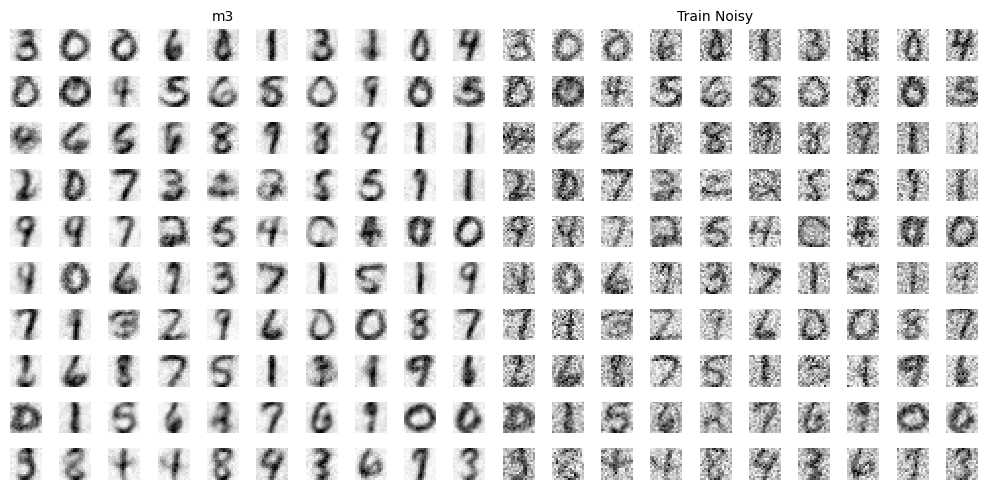

In [39]:

#Transformaciones PCA y KPCA
#X_pca = PCA().fit_transform(X)


kernel="poly"
gamma = 0.21


kpca = KernelPCA(kernel= kernel, gamma = gamma ,fit_inverse_transform=True).fit(X_back_m2)
X_kpca = kpca.transform(X_back_m2)
X_back_m3 = kpca.inverse_transform(X_kpca)

plot_parallel(X_back_m3, X_train_noisy, "m3", "Train Noisy")

#mse = calcular_mse(limpias=X_back)
#print("El MSE originales-limpias:", mse)

#mse = calcular_mse(limpias=X_train_noisy)
#print("El MSE originales-sucias:", mse)


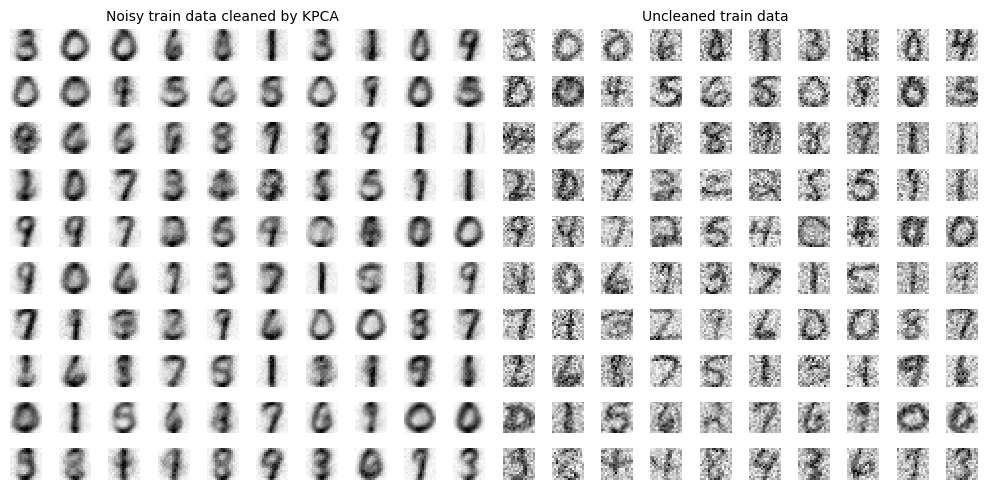

In [18]:
plot_parallel(X_back, X_train_noisy, "Noisy train data cleaned by KPCA", "Uncleaned train data")

In [113]:

# Función para aumentar el contraste de una imagen
def increase_contrast(image):
    # Escalar los valores de píxeles al rango [0, 255]
    min_val = np.min(image)
    max_val = np.max(image)
    scaled_image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # Aplicar la ecualización del histograma
    equalized = cv2.equalizeHist(scaled_image)

    return equalized


# Ejemplo de cómo usar la función
# Suponiendo que 'image' es tu imagen de 16x16 píxeles
X_contraste = increase_contrast(X_back)

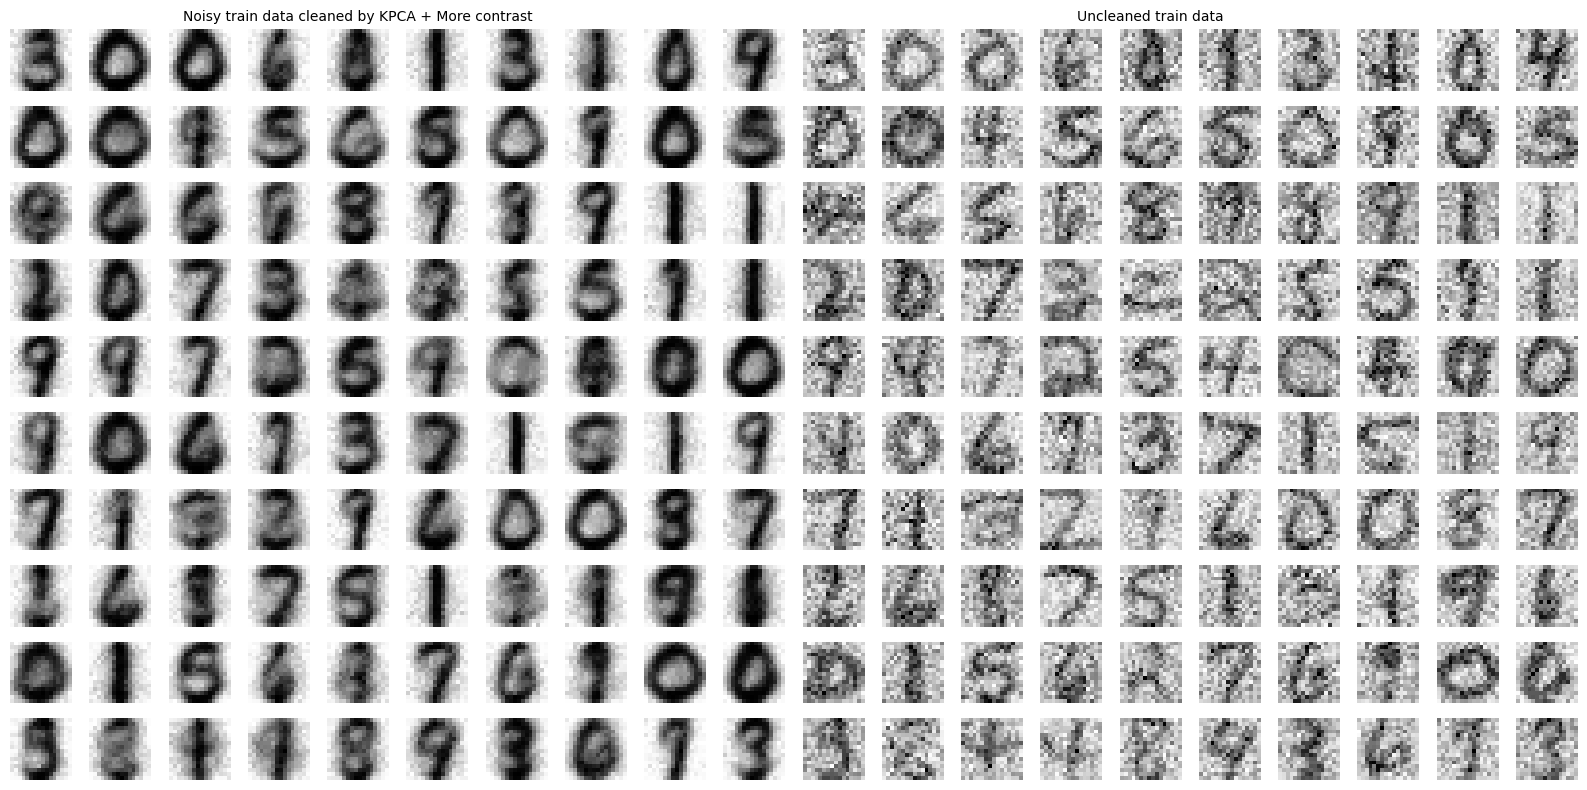

In [114]:
#X_contraste = X_contraste / 255.0
plot_parallel(X_contraste, X_train_noisy, "Noisy train data cleaned by KPCA + More contrast", "Uncleaned train data")

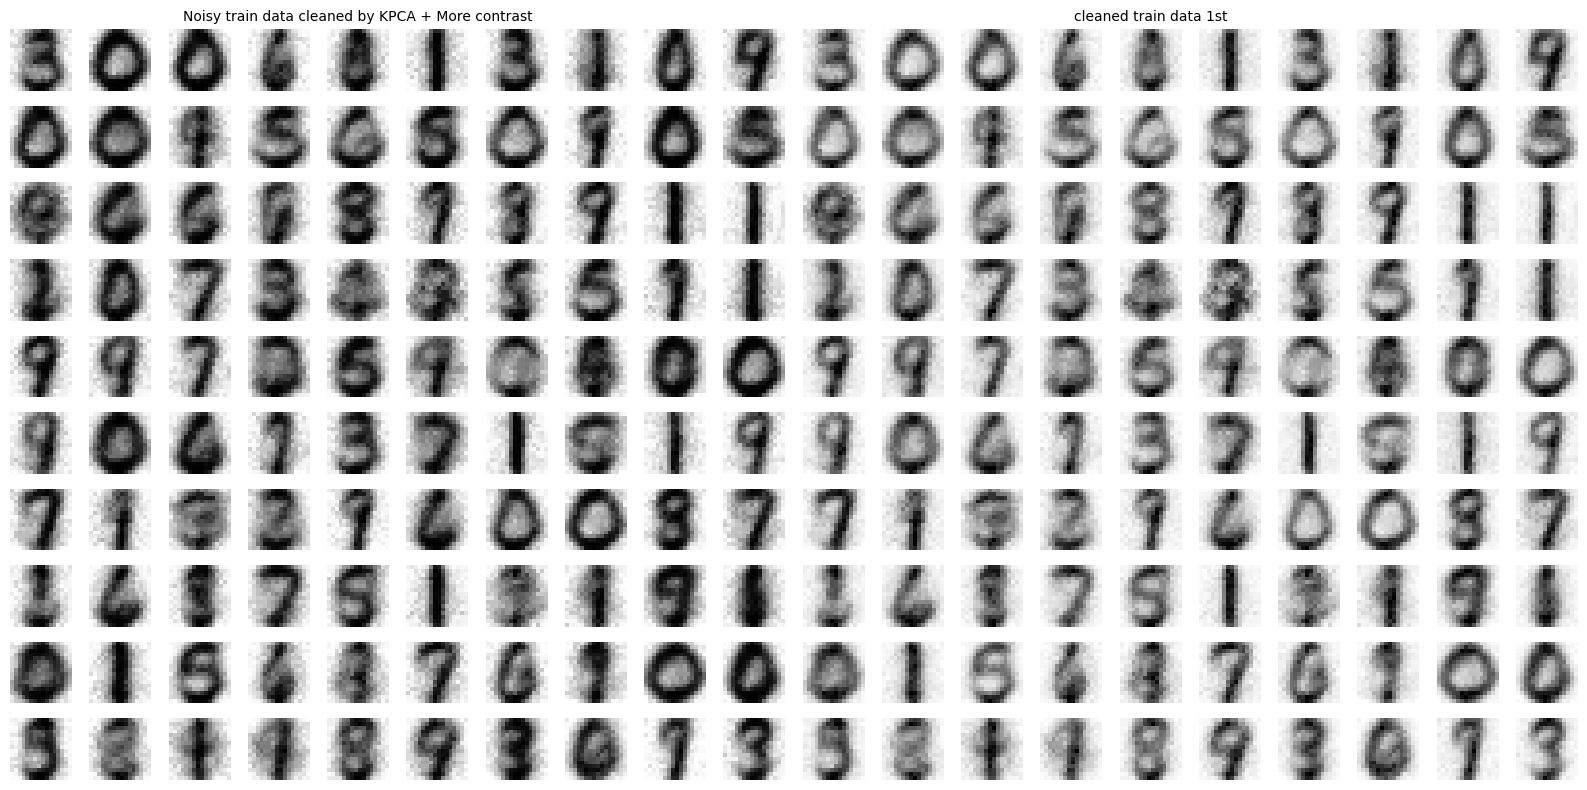

In [107]:
plot_parallel(X_contraste, X_back, "Noisy train data cleaned by KPCA + More contrast", "cleaned train data 1st")

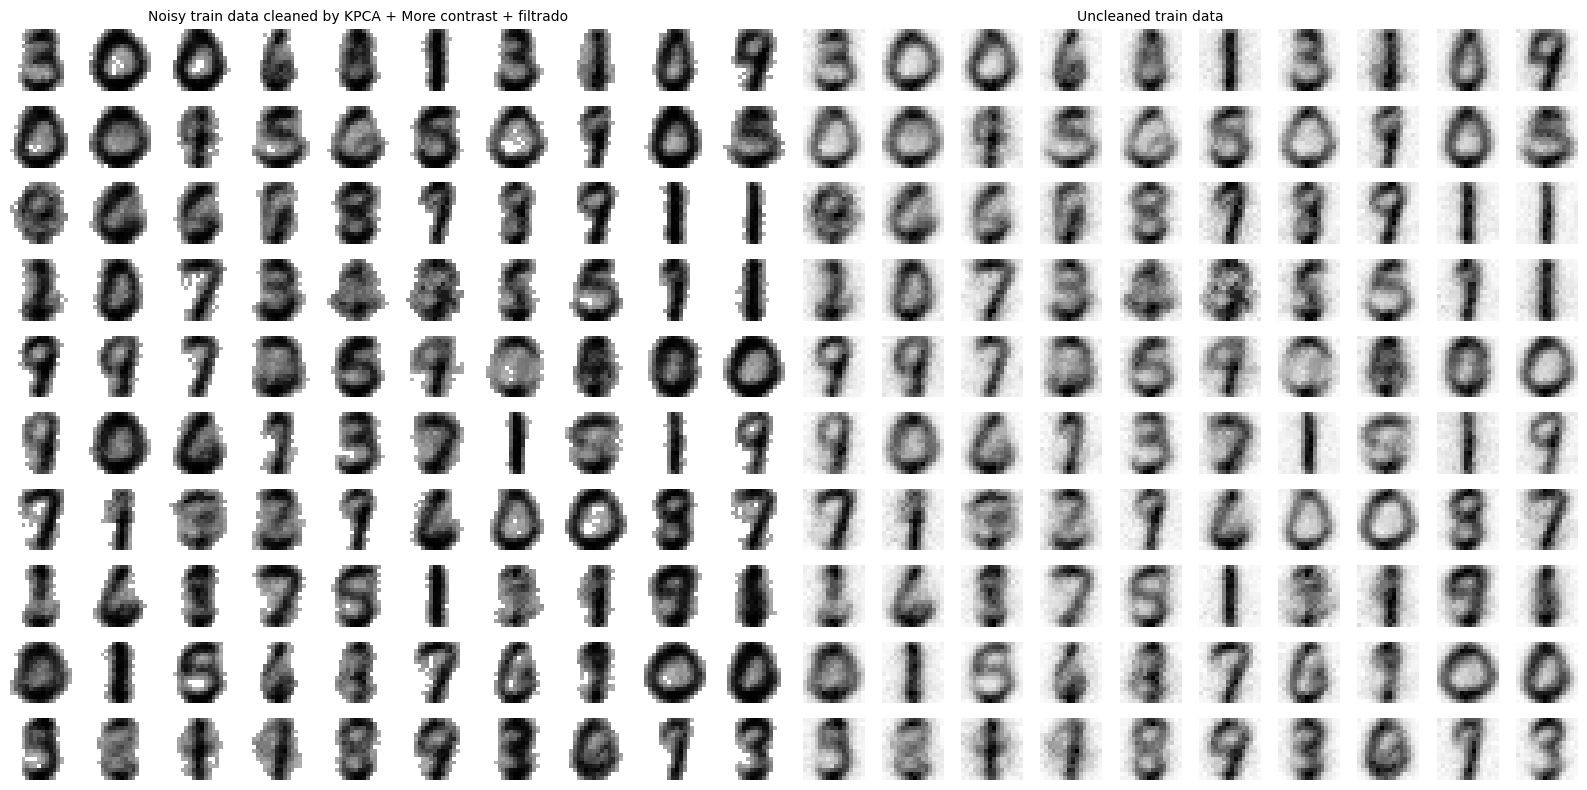

In [115]:
# Calcular el percentil 35 de valor de la imagen
percentil_35 = np.percentile(X_contraste, 40)

# Aplicar una máscara para establecer a 0 los píxeles por debajo del percentil 35
X_contraste_filtrado = np.where(X_contraste < percentil_35, 0, X_contraste)

plot_parallel(X_contraste_filtrado, X_back, "Noisy train data cleaned by KPCA + More contrast + filtrado", "Uncleaned train data")

X_back_2 = X_contraste_filtrado / 255.0

In [124]:
max_value = np.max(X_contraste)

# Calcular el umbral, que es el 60% del máximo valor
umbral = 0.66 * max_value

# Aplicar una máscara para establecer a 0 los píxeles por debajo del umbral
X_contraste_filtrado = np.where(X_contraste < umbral, 0, X_contraste)

X_back_2 = X_contraste_filtrado / 255.0

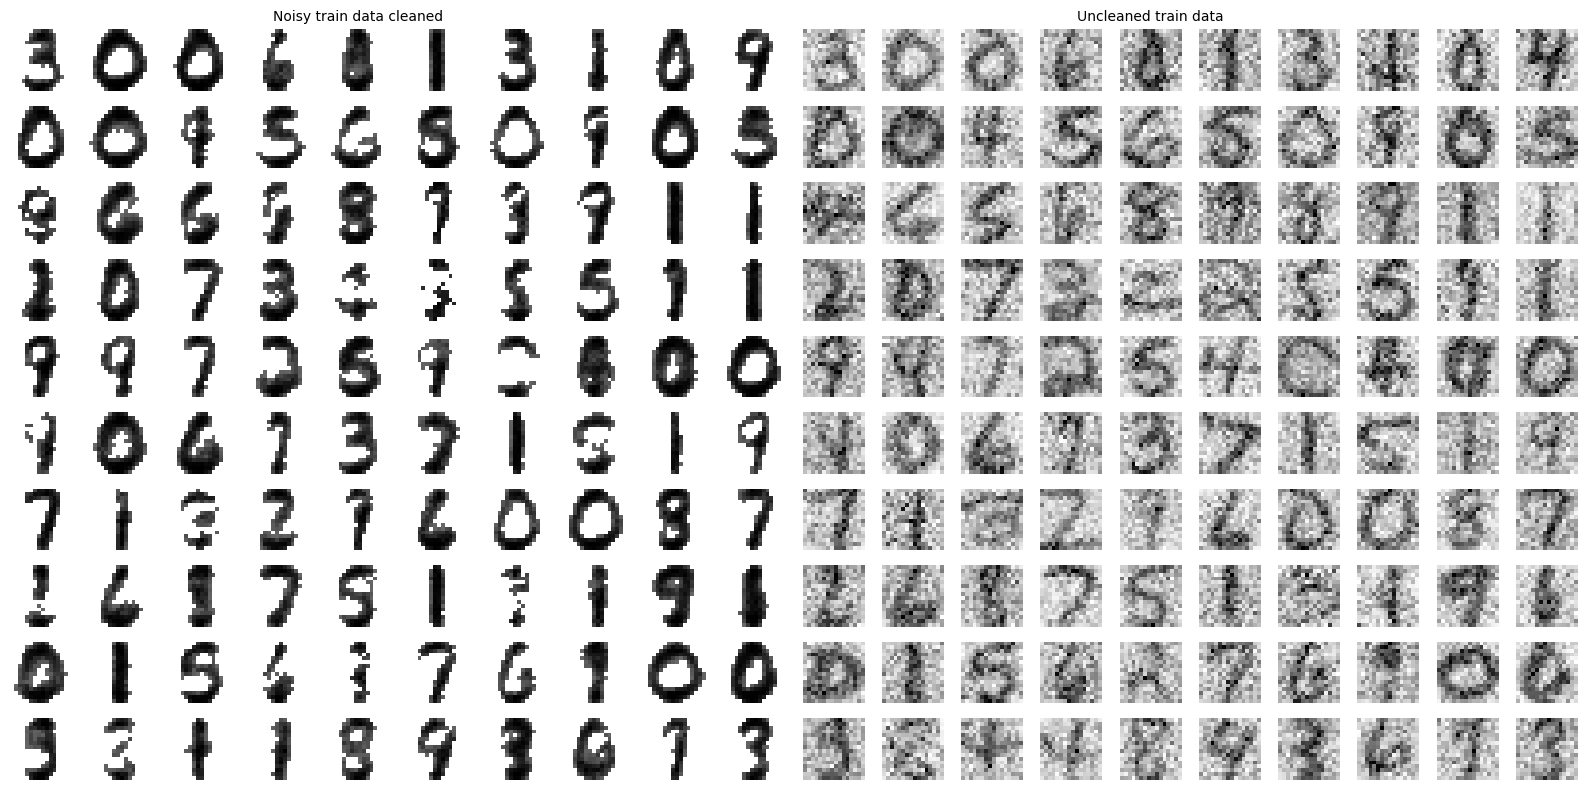

In [136]:
plot_parallel(X_back_2, X_train_noisy, "Noisy train data cleaned", "Uncleaned train data")

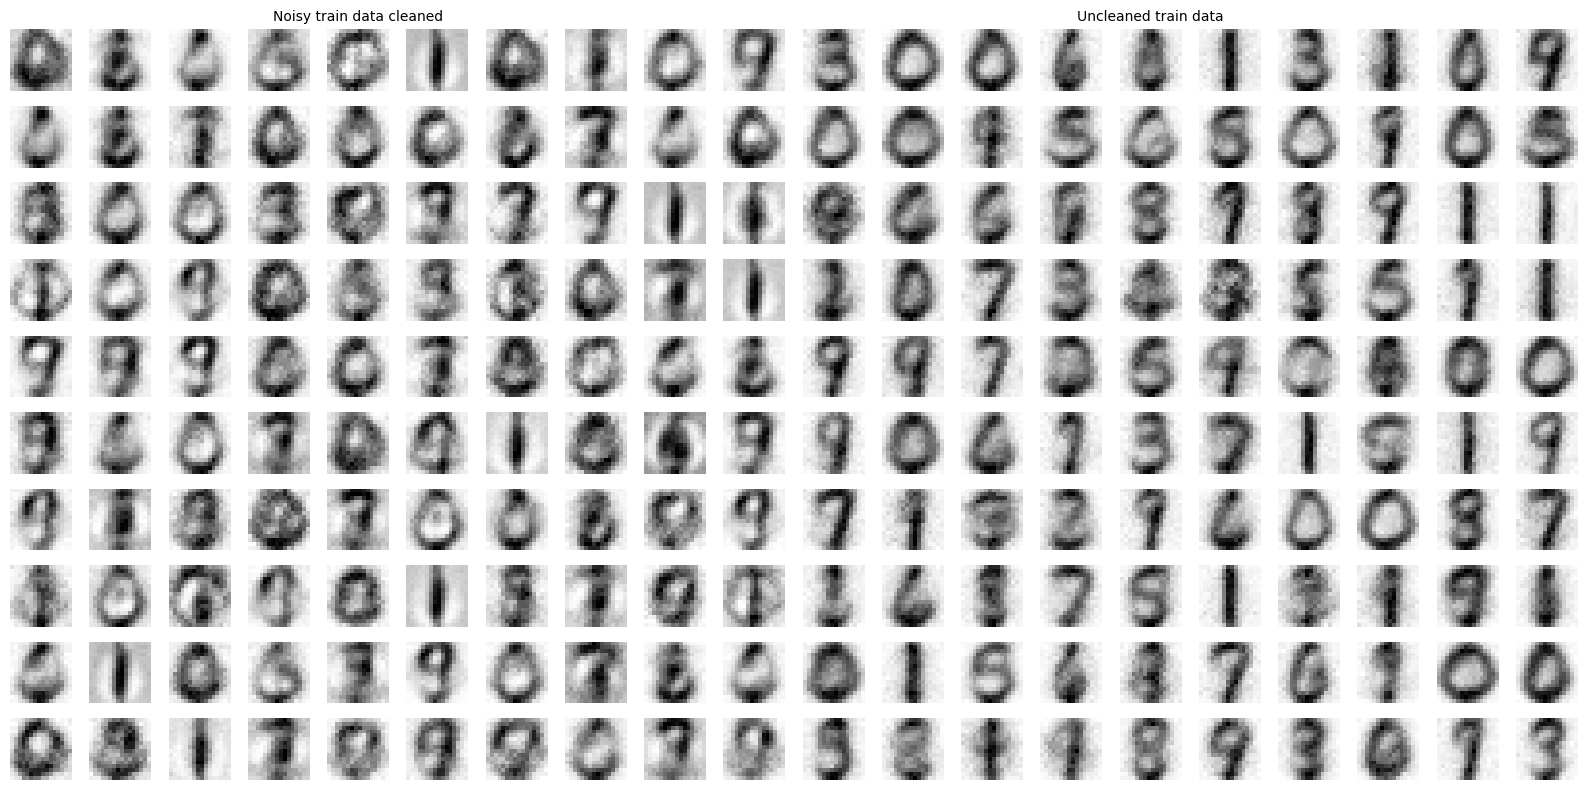

In [133]:


kernel="rbf"
gamma = 0.1
degree = 10

kpca_3 = KernelPCA(kernel= kernel, gamma = gamma, degree = degree ,fit_inverse_transform=True).fit(X_back_2)
X_kpca_3 = kpca_3.transform(X_back_2)
X_back_3 = kpca.inverse_transform(X_kpca_3)

plot_parallel(X_back_3, X_back, "Noisy train data cleaned", "Uncleaned train data")